In [2]:
import botorch
from known_boundary.acquisition_function import EI_acquisition_opt,SLogTEI_acquisition_opt,SLogEI_acquisition_opt
from known_boundary.utlis import  get_initial_points,transform,opt_model_MLE,opt_model_MAP
from scipy import stats
import math
import numpy as np
import GPy
import torch
from botorch.test_functions import Ackley,Levy,Beale,Branin,Hartmann,Rosenbrock,Powell,SixHumpCamel
from botorch.utils.transforms import unnormalize,normalize
from known_boundary.SLogGP import SLogGP
import scipy 

import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('lengthscale').disabled = True
logging.getLogger('variance').disabled = True
logging.getLogger('psi').disabled = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

In [2]:
function_information = []

dim=2

temp={}
temp['name']='Branin2D' 
temp['function'] = Branin(negate=False)
temp['X_new'] =  torch.tensor([9.42478,2.475]).reshape(1,dim)
temp['fstar'] =  0.397887
function_information.append(temp)

temp={}
temp['name']='Ackley2D' 
temp['function'] = Ackley(dim=2,negate=False)
temp['X_new'] =  torch.tensor([0.,0.]).reshape(1,dim)
temp['fstar'] =  0.
function_information.append(temp)

temp={}
temp['name']='Beale2D' 
temp['function'] =  Beale(negate=False)
temp['X_new'] =  torch.tensor([3,0.5]).reshape(1,dim)
temp['fstar'] =  0.
function_information.append(temp)

temp={}
temp['name']='Levy2D' 
temp['function'] = Levy(dim=2,negate=False)
temp['X_new'] =  torch.tensor([1.,1.]).reshape(1,dim)
temp['fstar'] =  0.
function_information.append(temp)

temp={}
temp['name']='Rosenbrock2D' 
temp['function'] = Rosenbrock(dim=2,negate=False)
temp['X_new'] =  torch.tensor([1.,1.]).reshape(1,dim)
temp['fstar'] =  0.
function_information.append(temp)

temp={}
temp['name']='SixHumpCamel2D' 
temp['function'] = SixHumpCamel(negate=False)
temp['X_new'] =  torch.tensor([0.0898,-0.7126]).reshape(1,dim)
temp['fstar'] =  -1.0317
function_information.append(temp)

In [4]:
for information in function_information:
    fun = information['function']
    dim = fun.dim
    bounds = fun.bounds
    standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)
    
    X_new = information['X_new']
        
    lengthscale_range = [0.01,2]
    variance_range = [0.01**2,4**2]
    noise = 1e-5
    
    N = 50
    
    ####################### GP ##########################
    GP_error_holder = []
    GP_prob_holder = []

    for i in range(N):
        #print(i)
        seed = i
        n_history = 50

        X_total = get_initial_points(bounds, n_history,device,dtype,seed=seed)
        Y_total = torch.tensor(
            [fun(x) for x in X_total], dtype=dtype, device=device
        ).reshape(-1,1)

        seed = i+100
        X_new = get_initial_points(bounds, 1,device,dtype,seed=seed)
        Y_new = torch.tensor(
            [fun(x) for x in X_new], dtype=dtype, device=device
        ).reshape(-1,1)

        np.random.seed(1234)


        train_Y = (Y_total - Y_total.mean()) / Y_total.std()
        train_X = normalize(X_total, bounds)


        train_Y = train_Y.numpy()
        train_X = train_X.numpy()

        # train the GP
        parameters = opt_model(train_X,train_Y,dim,'GP',noise=noise,lengthscale_range=lengthscale_range,variance_range=variance_range)
                
        lengthscale = parameters[0]
        variance = parameters[1]


        kernel = GPy.kern.RBF(input_dim=dim,lengthscale=lengthscale,variance=variance)
        m = GPy.models.GPRegression(train_X.reshape(-1,dim), train_Y.reshape(-1,1),kernel)
        m.Gaussian_noise.fix(noise)

        predict_mean, predict_var = m.predict(normalize(X_new, bounds).numpy())
        final_prediction = Y_total.std()*predict_mean+Y_total.mean()
        
        prob = stats.norm(loc = predict_mean , scale=math.sqrt(predict_var)).pdf(Y_new.item())
        
        GP_error_holder.append(abs(final_prediction.item()-Y_new.item()))
        GP_prob_holder.append(prob)
        
    print(information['name']+' prediction error (GP): ',np.mean(GP_error_holder))
    print(information['name']+' probability (GP): ',np.mean(GP_prob_holder))
    
######################## SLogGP #####################################

    SLogGP_error_holder = []
    SLogGP_prob_holder = []

    for i in range(N):
        #print(i)
        seed = i
        n_history = 50

        X_total = get_initial_points(bounds, n_history,device,dtype,seed=seed)
        Y_total = torch.tensor(
            [fun(x) for x in X_total], dtype=dtype, device=device
        ).reshape(-1,1)

        seed = i+100
        X_new = get_initial_points(bounds, 1,device,dtype,seed=seed)
        Y_new = torch.tensor(
            [fun(x) for x in X_new], dtype=dtype, device=device
        ).reshape(-1,1)

        np.random.seed(1234)


        train_Y = Y_total 
        train_X = normalize(X_total, bounds)


        train_Y = train_Y.numpy()
        train_X = train_X.numpy()
        
        lower = -np.min(train_Y)+10**(-6)
        upper = lower+500
        
        c_range = [lower,upper]

        # train the GP
        parameters = opt_model(train_X,train_Y,dim,'SLogGP',noise=noise,lengthscale_range=lengthscale_range,variance_range=variance_range,c_range=c_range)                
            
        lengthscale = parameters[0]
        variance = parameters[1]
        c = parameters[2]
        
        #print(c)
        
        warp_Y = np.log(train_Y+c)
        mean_warp_Y = np.mean(warp_Y) # use to predict mean
        warp_Y_standard = warp_Y-mean_warp_Y
        

        kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
        m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
        m.Gaussian_noise.variance.fix(noise)

        predict_mean,predict_var = m.predict(normalize(X_new, bounds).numpy())
        final_prediction = np.exp(predict_mean+mean_warp_Y+predict_var/2)-c
        
        prob = stats.lognorm(s=math.sqrt(predict_var), scale=math.exp(predict_mean+mean_warp_Y),loc=-c).pdf(Y_new.item())
        
        SLogGP_error_holder.append(abs(final_prediction.item()-Y_new.item()))
        SLogGP_prob_holder.append(prob)
        
    print(information['name']+' prediction error (SLogGP): ',np.mean(SLogGP_error_holder))
    print(information['name']+' probability (SLogGPGP): ',np.mean(SLogGP_prob_holder))
    print('################################################')

Branin2D prediction error (GP):  0.5128052709526331
Branin2D probability (GP):  0.0
Branin2D prediction error (SLogGP):  0.9319906261299576
Branin2D probability (SLogGPGP):  0.19054922203581037
################################################
Ackley2D prediction error (GP):  0.7785522943027456
Ackley2D probability (GP):  8.822417470125714e-116
Ackley2D prediction error (SLogGP):  0.5511124465567879
Ackley2D probability (SLogGPGP):  0.3364195581131434
################################################
Beale2D prediction error (GP):  1784.8702411061336
Beale2D probability (GP):  0.0
Beale2D prediction error (SLogGP):  7958.989489994551
Beale2D probability (SLogGPGP):  0.003909693763189538
################################################
Levy2D prediction error (GP):  6.969069989562908
Levy2D probability (GP):  0.00017113387762359778
Levy2D prediction error (SLogGP):  10.176616149528858
Levy2D probability (SLogGPGP):  0.05511753231269905
################################################
Rose

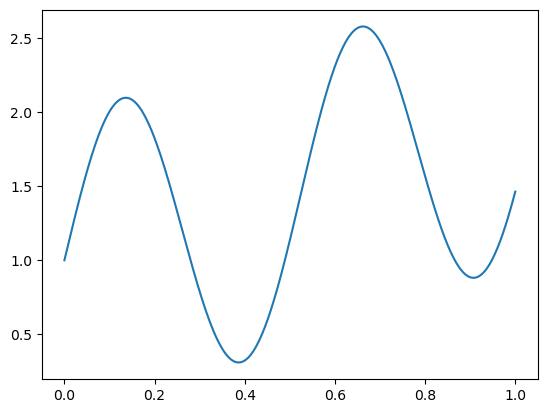

In [90]:
import matplotlib.pyplot as plt
from known_boundary.acquisition_function import EI,SLogEI

X_total = np.linspace(0,1,500)
Y_total = 2**X_total + np.sin(X_total*12) #+X_total**2-0.5*X_total+2**X_total

plt.plot(X_total,Y_total)

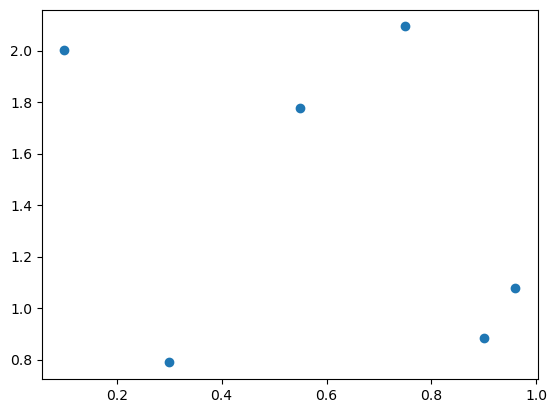

In [92]:
X_BO = np.array([0.1,0.3,0.55,0.75,0.9,0.96])
Y_BO = 2**X_BO + np.sin(X_BO*12) 

plt.scatter(X_BO,Y_BO)

In [93]:
lengthscale_range = [0.001,2]
variance_range = [0.001**2,4**2]
noise = 1e-6
seed = 1234
dim = 1

In [94]:
parameters = opt_model_MLE(X_BO,Y_BO,dim,'GP',noise=noise,seed=seed,lengthscale_range=lengthscale_range,variance_range=variance_range)
                        
lengthscale = parameters[0]
variance = parameters[1]

print(lengthscale)
print(variance)

kernel = GPy.kern.RBF(input_dim=dim,lengthscale=lengthscale,variance=variance)
m = GPy.models.GPRegression(X_BO.reshape(-1,dim), Y_BO.reshape(-1,1),kernel)
m.Gaussian_noise.fix(noise)

f_best = np.min(Y_BO)

0.151380880591266
2.3957279328947365


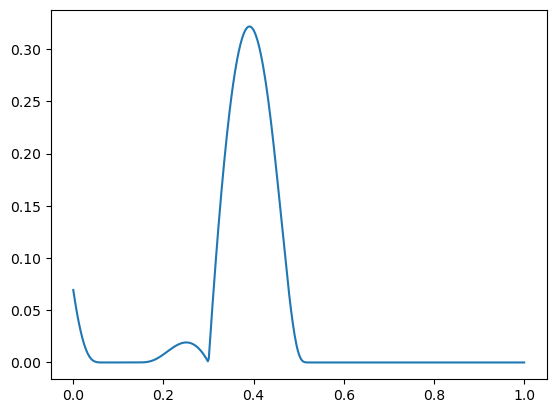

In [95]:
acq_val = EI(X_total,dim,f_best,m,f_star='no')
plt.plot(X_total,acq_val)

In [96]:
lower = -np.min(Y_BO)+10**(-6)
upper = lower+2000 #min(300,5*train_Y_std)

c_range = [lower,upper]
                
parameters = opt_model_MLE(X_BO,Y_BO,dim,'SLogGP',noise=noise,seed=seed,lengthscale_range=lengthscale_range,variance_range=variance_range,c_range=c_range)                
        
lengthscale = parameters[0]
variance = parameters[1]
c = parameters[2]

print('lengthscale is ',lengthscale)
print('variance is ',variance)
print('lower bound is ',-c)


warp_Y = np.log(Y_BO+c)
mean_warp_Y = np.mean(warp_Y) # use to predict mean
warp_Y_standard = warp_Y-mean_warp_Y


kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
m = GPy.models.GPRegression(X_BO.reshape(-1,dim), warp_Y_standard.reshape(-1,1),kernel)
m.Gaussian_noise.variance.fix(noise)

lengthscale is  0.07679023210045917
variance is  15.999999488958947
lower bound is  0.7886229700500642


array([0])

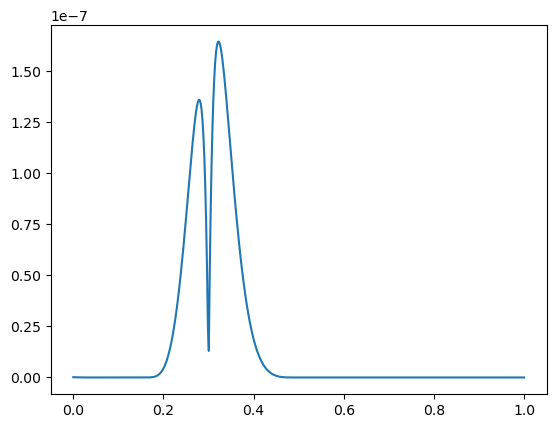

In [97]:
acq_val = SLogEI(X_total,dim,f_best,c,mean_warp_Y,m)
plt.plot(X_total,acq_val)